<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/Klamn_Filter_and_LR_for_MEF_estimation_May_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Descriptive statistics and data preprocessing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import bds

# Load the data
data = pd.read_excel('/content/MEF_2025.xlsx')

# Remove duplicate dates
data.drop(data.loc[data['Date'].duplicated()].index, inplace=True)

# Set 'Date' as the index and drop the 'Date' column
data.set_index(data['Date'], inplace=True)
data.drop(columns=['Date'], inplace=True)

# Display the last few rows of the data
print("Tail of the data:")
print(data.tail())

# Check for missing values
missing_rows = data[data.isna().any(axis=1)].tail()
cols_with_missing = data.columns[data.isna().any()].tolist()

# Prepare and print text results for missing values
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = f"Rows with missing values:\n{missing_rows.to_string(index=False)}"

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)

# Handle negative values in 'Generation'
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Handle zero values in 'Generation' by setting corresponding 'Emissions' to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Display the results of handling negative and zero values
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero values in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Calculate the first difference of the time series
ret = data - data.shift(1)
ret = ret[1:]  # Eliminate the first row which will be NaN

# Display the differenced data
print("First difference of the data:")
print(ret)

# Standardize the 'Generation' and 'Emissions' columns
scaler = StandardScaler()
ret['Generation'] = scaler.fit_transform(ret[['Generation']])
ret['Emissions'] = scaler.fit_transform(ret[['Emissions']])

# Display the standardized data
print("Standardized data:")
print(ret)

# Check for missing values in the standardized data
missing_rows_ret = ret[ret.isna().any(axis=1)].tail()
cols_with_missing_ret = ret.columns[ret.isna().any()].tolist()

# Prepare and print text results for missing values in the standardized data
if missing_rows_ret.empty:
    result_text_ret = "No rows with missing values found."
else:
    result_text_ret = f"Rows with missing values:\n{missing_rows_ret.to_string(index=False)}"

if not cols_with_missing_ret:
    result_text_ret += "\n\nNo columns with missing values."
else:
    result_text_ret += f"\n\nColumns with missing values: {', '.join(cols_with_missing_ret)}"

print(result_text_ret)

# Descriptive statistics
print("Descriptive statistics for original data:")
print(data.describe())

print("Descriptive statistics for first differenced and standardized data:")
print(ret.describe())


Tail of the data:
                     Emissions    Generation
Date                                        
2025-12-31 19:00:00       98.0  2.375951e+07
2025-12-31 20:00:00       98.0  2.373899e+07
2025-12-31 21:00:00       98.0  2.341670e+07
2025-12-31 22:00:00       98.0  2.292259e+07
2025-12-31 23:00:00      172.0  2.284948e+07
No rows with missing values found.

No columns with missing values.
Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero values in Generation: 0
Number of Emissions converted to zero: 0
First difference of the data:
                     Emissions    Generation
Date                                        
2025-01-01 01:00:00      -11.0 -4.557594e+05
2025-01-01 02:00:00      -11.0 -1.263355e+05
2025-01-01 03:00:00        1.0  6.891352e+05
2025-01-01 04:00:00        6.0  1.102548e+06
2025-01-01 05:00:00      -10.0 -4.008637e+05
...                        ...           ...
2025-12-31 19:00:00        0.0 -2.630233e+05
202

**Stationarity Test**

In [ ]:
# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[0], result[1], result[4]  # ADF Statistic, p-value, critical values

# Apply ADF test on each column in the original data
print("ADF Test for original data:")
for column in data.columns:
    adf_stat, p_value, crit_values = adf_test(data[column])
    print(f"{column}: ADF Statistic: {adf_stat}, p-value: {p_value}")
    for key, value in crit_values.items():
        print(f'   Critical Value ({key}): {value}')
    if p_value < 0.05:
        print(f"{column} is stationary.")
    else:
        print(f"{column} is not stationary.")
    print()

# Apply ADF test on each column in the differenced data
print("ADF Test for first differenced data (ret):")
for column in ret.columns:
    adf_stat, p_value, crit_values = adf_test(ret[column])
    print(f"{column}: ADF Statistic: {adf_stat}, p-value: {p_value}")
    for key, value in crit_values.items():
        print(f'   Critical Value ({key}): {value}')
    if p_value < 0.05:
        print(f"{column} is stationary.")
    else:
        print(f"{column} is not stationary.")
    print()

ADF Test for original data:
Emissions: ADF Statistic: -8.645680840359075, p-value: 5.2787973490110805e-14
   Critical Value (1%): -3.431099882538333
   Critical Value (5%): -2.8618713981324873
   Critical Value (10%): -2.56694639826003
Emissions is stationary.

Generation: ADF Statistic: -7.5109391295896994, p-value: 4.01733021507306e-11
   Critical Value (1%): -3.431099968539641
   Critical Value (5%): -2.86187143613454
   Critical Value (10%): -2.5669464184887825
Generation is stationary.

ADF Test for first differenced data (ret):
Emissions: ADF Statistic: -19.622125899909243, p-value: 0.0
   Critical Value (1%): -3.431099882538333
   Critical Value (5%): -2.8618713981324873
   Critical Value (10%): -2.56694639826003
Emissions is stationary.

Generation: ADF Statistic: -16.977691049242946, p-value: 9.060704444639274e-30
   Critical Value (1%): -3.431099968539641
   Critical Value (5%): -2.86187143613454
   Critical Value (10%): -2.5669464184887825
Generation is stationary.



BDS Linearity test

In [ ]:
# BDS Test
def bds_test(series):
    result = bds(series)
    return result

# Apply BDS test on each column in the original data
print("BDS Test for original data:")
for column in data.columns:
    print(f"BDS Test for {column}:")
    result = bds_test(data[column])
    print(result)
    if result[1] < 0.05:
        print(f"{column} is not i.i.d., suggesting non-linearity or dependence.")
    else:
        print(f"{column} is i.i.d., suggesting no significant non-linearity or dependence.")
    print()

# Apply BDS test on each column in the differenced data
print("BDS Test for first differenced data (ret):")
for column in ret.columns:
    print(f"BDS Test for {column}:")
    result = bds_test(ret[column])
    print(result)
    if result[1] < 0.05:
        print(f"{column} is not i.i.d., suggesting non-linearity or dependence.")
    else:
        print(f"{column} is i.i.d., suggesting no significant non-linearity or dependence.")
    print()

BDS Test for original data:
BDS Test for Emissions:
(array(204.32041576), array(0.))
Emissions is not i.i.d., suggesting non-linearity or dependence.

BDS Test for Generation:
(array(274.58318609), array(0.))
Generation is not i.i.d., suggesting non-linearity or dependence.

BDS Test for first differenced data (ret):
BDS Test for Emissions:
(array(28.45051958), array(4.80148391e-178))
Emissions is not i.i.d., suggesting non-linearity or dependence.

BDS Test for Generation:
(array(12.59284274), array(2.3119462e-36))
Generation is not i.i.d., suggesting non-linearity or dependence.



# **All descriptive statistics**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import bds

# Load the data
data = pd.read_excel('/content/MEF_2025.xlsx')

# Remove duplicate dates
data.drop(data.loc[data['Date'].duplicated()].index, inplace=True)

# Set 'Date' as the index and drop the 'Date' column
data.set_index(data['Date'], inplace=True)
data.drop(columns=['Date'], inplace=True)

# Display the last few rows of the data
print("Tail of the data:")
print(data.tail())

# Check for missing values
missing_rows = data[data.isna().any(axis=1)].tail()
cols_with_missing = data.columns[data.isna().any()].tolist()

# Prepare and print text results for missing values
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = f"Rows with missing values:\n{missing_rows.to_string(index=False)}"

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)

# Handle negative values in 'Generation'
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Handle zero values in 'Generation' by setting corresponding 'Emissions' to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Display the results of handling negative and zero values
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero values in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Calculate the first difference of the time series
ret = data - data.shift(1)
ret = ret[1:]  # Eliminate the first row which will be NaN

# Display the differenced data
print("First difference of the data:")
print(ret)

# Standardize the 'Generation' and 'Emissions' columns
scaler = StandardScaler()
ret['Generation'] = scaler.fit_transform(ret[['Generation']])
ret['Emissions'] = scaler.fit_transform(ret[['Emissions']])

# Display the standardized data
print("Standardized data:")
print(ret)

# Check for missing values in the standardized data
missing_rows_ret = ret[ret.isna().any(axis=1)].tail()
cols_with_missing_ret = ret.columns[ret.isna().any()].tolist()

# Prepare and print text results for missing values in the standardized data
if missing_rows_ret.empty:
    result_text_ret = "No rows with missing values found."
else:
    result_text_ret = f"Rows with missing values:\n{missing_rows_ret.to_string(index=False)}"

if not cols_with_missing_ret:
    result_text_ret += "\n\nNo columns with missing values."
else:
    result_text_ret += f"\n\nColumns with missing values: {', '.join(cols_with_missing_ret)}"

print(result_text_ret)

# Descriptive statistics
desc_stats_data = data.describe()
desc_stats_ret = ret.describe()

# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return result[0], result[1], result[4]  # ADF Statistic, p-value, critical values

# Apply ADF test on each column in the original data
adf_results_data = {}
for column in data.columns:
    adf_stat, p_value, crit_values = adf_test(data[column])
    adf_results_data[column] = (adf_stat, p_value, crit_values)

# Apply ADF test on each column in the differenced data
adf_results_ret = {}
for column in ret.columns:
    adf_stat, p_value, crit_values = adf_test(ret[column])
    adf_results_ret[column] = (adf_stat, p_value, crit_values)

# BDS Test
def bds_test(series):
    result = bds(series)
    return result

# Apply BDS test on each column in the original data
bds_results_data = {}
for column in data.columns:
    result = bds_test(data[column])
    bds_results_data[column] = result

# Apply BDS test on each column in the differenced data
bds_results_ret = {}
for column in ret.columns:
    result = bds_test(ret[column])
    bds_results_ret[column] = result

# Combine descriptive statistics and test results into a single DataFrame
def combine_results(desc_stats_data, adf_results_data, bds_results_data, desc_stats_ret, adf_results_ret, bds_results_ret):
    combined = pd.DataFrame()

    for column in desc_stats_data.columns:
        combined[column] = desc_stats_data[column]
        adf_stat, adf_pvalue, _ = adf_results_data[column]
        bds_stat, bds_pvalue, *_ = bds_results_data[column]
        combined.loc['ADF Statistic', column] = adf_stat
        combined.loc['ADF p-value', column] = adf_pvalue
        combined.loc['BDS Statistic', column] = bds_stat
        combined.loc['BDS p-value', column] = bds_pvalue

    for column in desc_stats_ret.columns:
        combined[column + " (Diff)"] = desc_stats_ret[column]
        adf_stat, adf_pvalue, _ = adf_results_ret[column]
        bds_stat, bds_pvalue, *_ = bds_results_ret[column]
        combined.loc['ADF Statistic', column + " (Diff)"] = adf_stat
        combined.loc['ADF p-value', column + " (Diff)"] = adf_pvalue
        combined.loc['BDS Statistic', column + " (Diff)"] = bds_stat
        combined.loc['BDS p-value', column + " (Diff)"] = bds_pvalue

    return combined

combined_results = combine_results(desc_stats_data, adf_results_data, bds_results_data, desc_stats_ret, adf_results_ret, bds_results_ret)

# Generate LaTeX table
def generate_latex_table(df, title):
    latex_table = df.to_latex()
    print(f"\nLaTeX Table for {title}:\n")
    print(latex_table)

generate_latex_table(combined_results, "Descriptive Statistics and Test Results")


Tail of the data:
                     Emissions    Generation
Date                                        
2025-12-31 19:00:00       98.0  2.375951e+07
2025-12-31 20:00:00       98.0  2.373899e+07
2025-12-31 21:00:00       98.0  2.341670e+07
2025-12-31 22:00:00       98.0  2.292259e+07
2025-12-31 23:00:00      172.0  2.284948e+07
No rows with missing values found.

No columns with missing values.
Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero values in Generation: 0
Number of Emissions converted to zero: 0
First difference of the data:
                     Emissions    Generation
Date                                        
2025-01-01 01:00:00      -11.0 -4.557594e+05
2025-01-01 02:00:00      -11.0 -1.263355e+05
2025-01-01 03:00:00        1.0  6.891352e+05
2025-01-01 04:00:00        6.0  1.102548e+06
2025-01-01 05:00:00      -10.0 -4.008637e+05
...                        ...           ...
2025-12-31 19:00:00        0.0 -2.630233e+05
202

# **Estimation**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_excel('/content/MEF_2019.xlsx')

# Remove duplicate dates
data.drop(data.loc[data['Date'].duplicated()].index, inplace=True)

# Set 'Date' as the index and drop the 'Date' column
data.set_index(data['Date'], inplace=True)
data.drop(columns=['Date'], inplace=True)

# Display the last few rows of the data
print("Tail of the data:")
print(data.tail())

# Check for missing values
missing_rows = data[data.isna().any(axis=1)].tail()
cols_with_missing = data.columns[data.isna().any()].tolist()

# Prepare and print text results for missing values
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = f"Rows with missing values:\n{missing_rows.to_string(index=False)}"

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)

# Handle negative values in 'Generation'
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Handle zero values in 'Generation' by setting corresponding 'Emissions' to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Display the results of handling negative and zero values
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero values in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Calculate the first difference of the time series
ret = data - data.shift(1)
ret = ret[1:]  # Eliminate the first row which will be NaN

# Display the differenced data
print("First difference of the data:")
print(ret)

# Standardize the 'Generation' and 'Emissions' columns
scaler = StandardScaler()
ret['Generation'] = scaler.fit_transform(ret[['Generation']])
ret['Emissions'] = scaler.fit_transform(ret[['Emissions']])

# Display the standardized data
print("Standardized data:")
print(ret)

# Check for missing values in the standardized data
missing_rows_ret = ret[ret.isna().any(axis=1)].tail()
cols_with_missing_ret = ret.columns[ret.isna().any()].tolist()

# Prepare and print text results for missing values in the standardized data
if missing_rows_ret.empty:
    result_text_ret = "No rows with missing values found."
else:
    result_text_ret = f"Rows with missing values:\n{missing_rows_ret.to_string(index=False)}"

if not cols_with_missing_ret:
    result_text_ret += "\n\nNo columns with missing values."
else:
    result_text_ret += f"\n\nColumns with missing values: {', '.join(cols_with_missing_ret)}"

print(result_text_ret)


Tail of the data:
                         Emissions    Generation
Date                                            
2019-12-31 18:59:59.982        730  2.483138e+07
2019-12-31 19:59:59.982        683  5.269565e+07
2019-12-31 20:59:59.982        645  5.269565e+07
2019-12-31 21:59:59.982        579  2.263845e+07
2019-12-31 22:59:59.982        512  2.096735e+07
No rows with missing values found.

No columns with missing values.
Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero values in Generation: 0
Number of Emissions converted to zero: 0
First difference of the data:
                         Emissions    Generation
Date                                            
2019-01-01 00:59:59.983        0.0  0.000000e+00
2019-01-01 01:59:59.983       42.0  6.071983e+06
2019-01-01 02:59:59.983      -35.0 -6.071983e+06
2019-01-01 04:00:00.000        0.0  0.000000e+00
2019-01-01 04:59:59.983      -92.0  0.000000e+00
...                            ...   

# **Dynamic linear Regression**

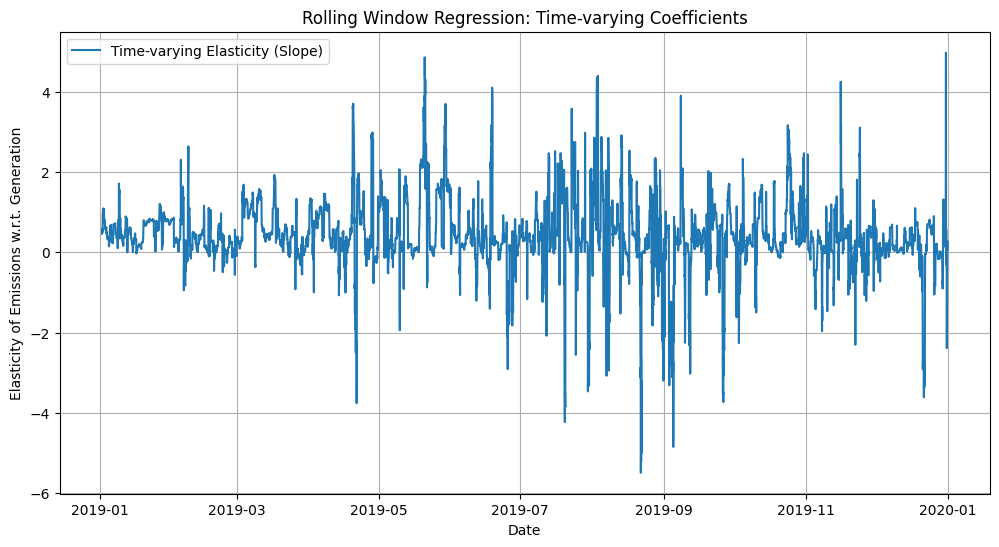

Results saved to Excel.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the window size for rolling regression
window_size = 24

# Prepare the data for regression using the differenced and standardized data 'ret'
ret['lr_Predicted_Emissions'] = np.nan
ret['lr_intercept'] = np.nan
ret['lr_coeff'] = np.nan
ret['lr_MSE'] = np.nan
ret['lr_RMSE'] = np.nan
ret['lr_MAE'] = np.nan

# Perform rolling regression
for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i - window_size:i]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    X_train = train['Generation'].values.reshape(-1, 1)
    y_train = train['Emissions'].values
    X_test = test['Generation'].values.reshape(-1, 1)
    y_test = test['Emissions'].values

    # Linear Regression
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)

    index_number = test.index.values
    ret.loc[index_number, 'lr_Predicted_Emissions'] = lr_predictions
    ret.loc[index_number, 'lr_intercept'] = lr.intercept_
    ret.loc[index_number, 'lr_coeff'] = lr.coef_[0]
    ret.loc[index_number, 'lr_MSE'] = mean_squared_error(y_test, lr_predictions)
    ret.loc[index_number, 'lr_RMSE'] = mean_squared_error(y_test, lr_predictions, squared=False)
    ret.loc[index_number, 'lr_MAE'] = mean_absolute_error(y_test, lr_predictions)

# Extract the valid indices where predictions are available
valid_indices = ret.dropna(subset=['lr_Predicted_Emissions']).index

# Retrieve the time-varying coefficients and predicted emissions
coefficients_index = ret.loc[valid_indices].index
intercepts = ret.loc[valid_indices, 'lr_intercept']
slopes = ret.loc[valid_indices, 'lr_coeff']
predicted_emissions = ret.loc[valid_indices, 'lr_Predicted_Emissions']

# Plotting the time-varying coefficient (slope)
plt.figure(figsize=(12, 6))
plt.plot(coefficients_index, slopes, label='Time-varying Elasticity (Slope)')
plt.title('Rolling Window Regression: Time-varying Coefficients')
plt.xlabel('Date')
plt.ylabel('Elasticity of Emissions w.r.t. Generation')
plt.legend()
plt.grid(True)
plt.show()

# Save results to Excel
results_df = pd.DataFrame({
    'Date': coefficients_index,
    'Intercept': intercepts,
    'Slope': slopes,
    'Predicted Emissions': predicted_emissions
})
results_df.to_excel('/content/Linear_regression_results.xlsx', index=False)

print("Results saved to Excel.")


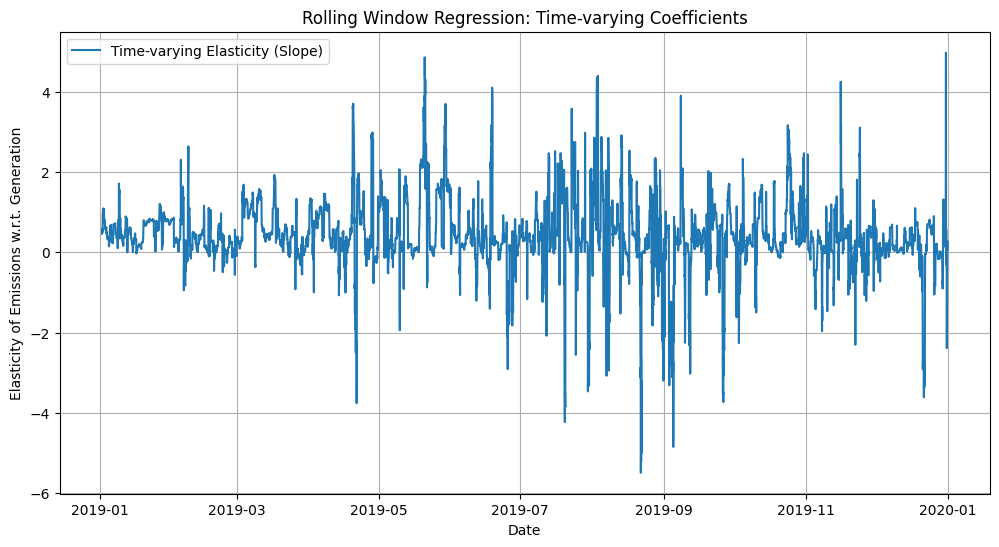

Results saved to Excel.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the window size for rolling regression
window_size = 24

# Prepare the data for regression using the differenced and standardized data 'ret'
ret['lr_Predicted_Emissions'] = np.nan
ret['lr_intercept'] = np.nan
ret['lr_coeff'] = np.nan
ret['lr_MSE'] = np.nan
ret['lr_RMSE'] = np.nan
ret['lr_MAE'] = np.nan

# Perform rolling regression
for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i-window_size:i]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    X_train = train['Generation'].values.reshape(-1, 1)
    y_train = train['Emissions'].values
    X_test = test['Generation'].values.reshape(-1, 1)
    y_test = test['Emissions'].values

    # Linear Regression
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)

    index_number = test.index.values
    ret.loc[index_number, 'lr_Predicted_Emissions'] = lr_predictions
    ret.loc[index_number, 'lr_intercept'] = lr.intercept_
    ret.loc[index_number, 'lr_coeff'] = lr.coef_[0]
    ret.loc[index_number, 'lr_MSE'] = mean_squared_error(y_test, lr_predictions)
    ret.loc[index_number, 'lr_RMSE'] = mean_squared_error(y_test, lr_predictions, squared=False)
    ret.loc[index_number, 'lr_MAE'] = mean_absolute_error(y_test, lr_predictions)

# Extract the valid indices where predictions are available
valid_indices = ret.dropna(subset=['lr_Predicted_Emissions']).index

# Retrieve the time-varying coefficients
coefficients_index = ret.loc[valid_indices].index
intercepts = ret.loc[valid_indices, 'lr_intercept']
slopes = ret.loc[valid_indices, 'lr_coeff']

# Plotting the time-varying coefficient (slope)
plt.figure(figsize=(12, 6))
plt.plot(coefficients_index, slopes, label='Time-varying Elasticity (Slope)')
plt.title('Rolling Window Regression: Time-varying Coefficients')
plt.xlabel('Date')
plt.ylabel('Elasticity of Emissions w.r.t. Generation')
plt.legend()
plt.grid(True)
plt.show()

# Save results to Excel
results_df = pd.DataFrame({
    'Date': coefficients_index,
    'Intercept': intercepts,
    'Slope': slopes
})
results_df.to_excel('/content/rolling_regression_results.xlsx', index=False)

print("Results saved to Excel.")


# **Kalman Filter Only**

Streaming output truncated to the last 5000 lines.
<ipython-input-8-ea0d0d4b5746>:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf_predictions[j] = x[0] + x[1] * test['Generation'].iloc[j]
<ipython-input-8-ea0d0d4b5746>:57: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alphas[j] = x[0]
<ipython-input-8-ea0d0d4b5746>:58: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  betas[j] = x[1]
<ipython-input-8-ea0d0d4b5746>:59: DeprecationWarning: Conversion of an array wit

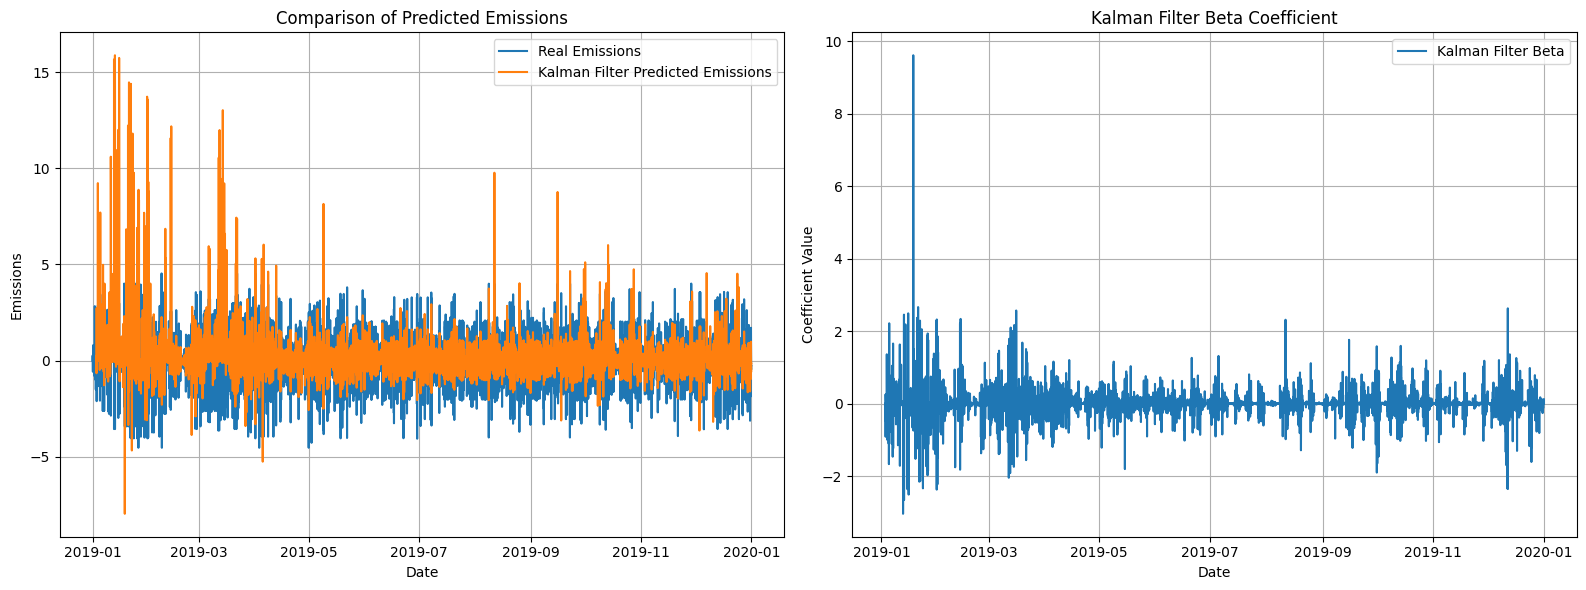

Results saved to Excel.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

# Assuming 'ret' is your DataFrame with 'Generation' and 'Emissions' columns

# Define the window size for rolling regression
window_size = 48

# Prepare the data for the Kalman filter
ret['kf_alpha'] = np.nan
ret['kf_beta'] = np.nan
ret['kf_predicted_emissions'] = np.nan

# Perform rolling regression
for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i-window_size:i]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    # Calculate the residuals from the initial regression model
    residuals = train['Emissions'] - train['Emissions'].mean()

    # Estimate the initial variance of the residuals
    var_eps_ols = np.var(residuals)

    # Estimate the initial covariance matrix of alpha and beta
    P = np.cov(residuals, train['Generation'], ddof=0)

    # Estimate the variances of the process noise
    eta_alpha = np.var(residuals) / len(residuals)
    eta_beta = np.var(train['Generation']) / len(residuals)
    Q = np.diag([eta_alpha, eta_beta])

    # Initialize the other variables for the Kalman filter
    x = np.array([[train['Emissions'].mean()], [0]])  # initial mean of alpha and beta
    R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
    F = np.eye(2)  # transition matrix
    H = np.vstack((np.ones(len(train)), train['Generation'].values)).T  # measurement matrix

    alphas, betas = np.full(len(test), np.nan), np.full(len(test), np.nan)
    kf_predictions = np.zeros(len(test))
    for j, y in enumerate(test['Emissions']):
        # predict
        x = F @ x
        P = (F @ P @ F.T) + Q

        # update
        S = (H[None, j] @ P @ H[None, j].T) + R  # Here S is a scalar
        K = (P @ H[None, j].T) @ inv(S)
        r = y - H[None, j] @ x  # residuals
        x = x + K @ r  # v is a scalar.
        P = P - K @ H[None, j] @ P  # K @ H[None,i] is an outer product

        alphas[j] = x[0]
        betas[j] = x[1]
        kf_predictions[j] = x[0] + x[1] * test['Generation'].iloc[j]

    index_number = test.index.values
    ret.loc[index_number, 'kf_alpha'] = alphas
    ret.loc[index_number, 'kf_beta'] = betas
    ret.loc[index_number, 'kf_predicted_emissions'] = kf_predictions

# Plotting the predicted emissions and coefficients from the Kalman filter model
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(ret.index, ret['Emissions'], label="Real Emissions")
plt.plot(ret.index, ret['kf_predicted_emissions'], label="Kalman Filter Predicted Emissions")
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Comparison of Predicted Emissions')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ret.index, ret['kf_beta'], label="Kalman Filter Beta")
plt.xlabel('Date')
plt.ylabel('Coefficient Value')
plt.title('Kalman Filter Beta Coefficient')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save results to Excel
results_df = ret[['Emissions', 'kf_predicted_emissions', 'kf_beta']]
results_df.to_excel('kalman_filter_results.xlsx', index=True)

print("Results saved to Excel.")


# **Kalman Filter vs OLS**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from sklearn.linear_model import LinearRegression

# Assuming 'ret' is your DataFrame with 'Generation' and 'Emissions' columns

# Define the window size for rolling regression
window_size = 48

# Prepare the data for regression using the differenced and standardized data 'ret'
ret['kf_alpha'] = np.nan
ret['kf_beta'] = np.nan
ret['ols_predicted_emissions'] = np.nan
ret['kf_predicted_emissions'] = np.nan
ret['ols_beta'] = np.nan

# Perform rolling regression
for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i-window_size:i]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    # OLS Linear Regression
    lr = LinearRegression()
    lr.fit(train['Generation'].values.reshape(-1, 1), train['Emissions'])
    ols_predictions = lr.predict(test['Generation'].values.reshape(-1, 1))

    # Calculate the residuals from the linear regression model
    residuals = train['Emissions'] - lr.predict(train['Generation'].values.reshape(-1, 1))

    # Estimate the initial variance of the residuals
    var_eps_ols = np.var(residuals)

    # Estimate the initial covariance matrix of alpha and beta
    P = np.cov(residuals, lr.predict(train['Generation'].values.reshape(-1, 1)), ddof=0)

    # Estimate the variances of the process noise
    eta_alpha = np.var(residuals) / len(residuals)
    eta_beta = np.var(lr.predict(train['Generation'].values.reshape(-1, 1))) / len(residuals)
    Q = np.diag([eta_alpha, eta_beta])

    # Initialize the other variables for the Kalman filter
    x = np.array([[lr.intercept_], [lr.coef_[0]]])  # initial mean of alpha and beta
    R = np.array([[var_eps_ols]])  # variance for the measurement - 1 dim
    F = np.eye(2)  # transition matrix
    H = np.vstack((np.ones(len(train)), train['Generation'].values)).T  # measurement matrix

    alphas, betas = np.full(len(test), np.nan), np.full(len(test), np.nan)
    kf_predictions = np.zeros(len(test))
    for j, y in enumerate(test['Emissions']):
        # predict
        x = F @ x
        P = (F @ P @ F.T) + Q

        # update
        S = (H[None, j] @ P @ H[None, j].T) + R  # Here S is a scalar
        K = (P @ H[None, j].T) @ inv(S)
        r = y - H[None, j] @ x  # residuals
        x = x + K @ r  # v is a scalar.
        P = P - K @ H[None, j] @ P  # K @ H[None,i] is an outer product

        alphas[j] = x[0]
        betas[j] = x[1]
        kf_predictions[j] = x[0] + x[1] * test['Generation'].iloc[j]

    index_number = test.index.values
    ret.loc[index_number, 'kf_alpha'] = alphas
    ret.loc[index_number, 'kf_beta'] = betas
    ret.loc[index_number, 'ols_predicted_emissions'] = ols_predictions
    ret.loc[index_number, 'kf_predicted_emissions'] = kf_predictions
    ret.loc[index_number, 'ols_beta'] = lr.coef_[0]  # Adding OLS beta to the DataFrame

# Plotting the predicted emissions and coefficients from both models
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(ret.index, ret['Emissions'], label="Real Emissions")
plt.plot(ret.index, ret['ols_predicted_emissions'], label="OLS Predicted Emissions")
plt.plot(ret.index, ret['kf_predicted_emissions'], label="Kalman Filter Predicted Emissions")
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Comparison of Predicted Emissions')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ret.index, ret['kf_beta'], label="Kalman Filter Beta")
plt.plot(ret.index, ret['ols_beta'], label="OLS Beta", linestyle='--')
plt.xlabel('Date')
plt.ylabel('Coefficient Value')
plt.title('Comparison of Beta Coefficients')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save results to Excel
results_df = ret[['Emissions', 'ols_predicted_emissions', 'kf_predicted_emissions', 'kf_beta', 'ols_beta']]
results_df.to_excel('rolling_regression_results.xlsx', index=True)

print("Results saved to Excel.")


# **Kalman Filter vs Regression with condition on the coeficients between 0 and 1**

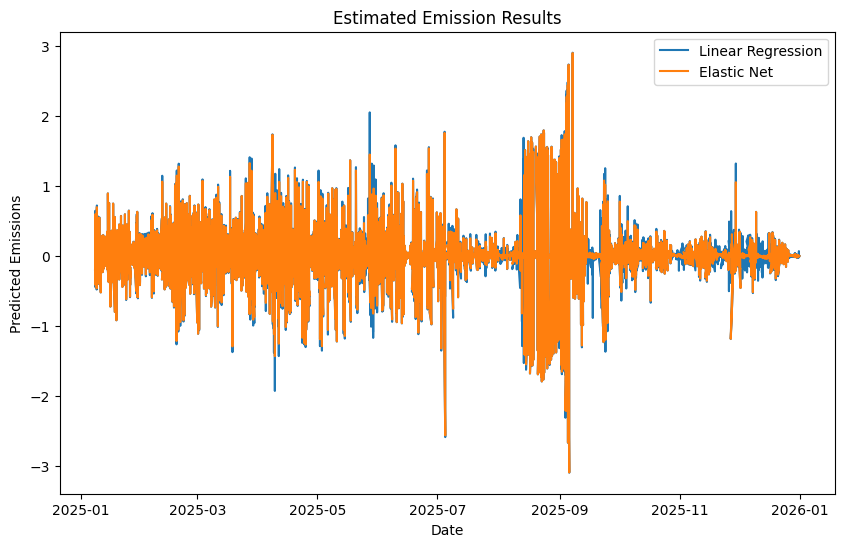

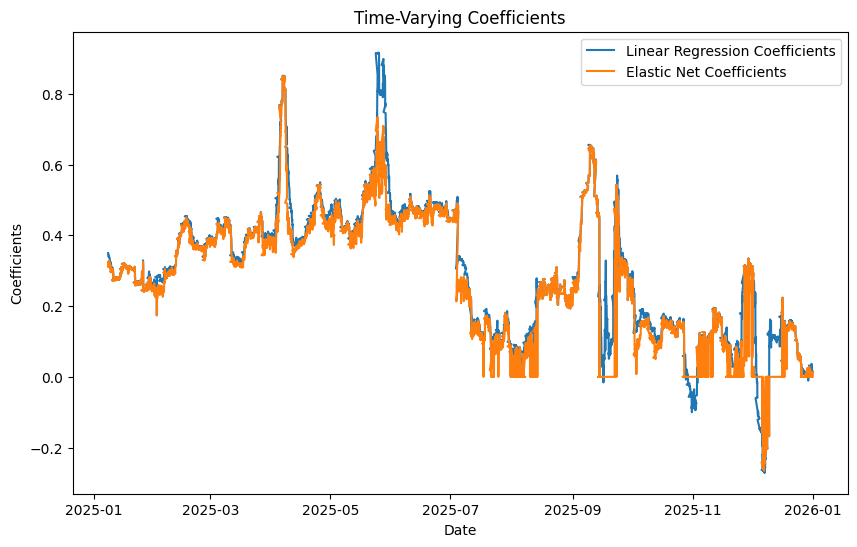

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

window_size = 168

# Ensure 'ret' DataFrame has a datetime index
ret.index = pd.to_datetime(ret.index)

# Create an empty DataFrame to store results
results = pd.DataFrame(columns=['Date', 'lr_Predicted_Emissions', 'en_Predicted_Emissions'])

# Create empty lists to store coefficients for plotting
lr_coefficients = []
en_coefficients = []

for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i-window_size:i+1]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    X_train = train['Generation'].values.reshape(-1, 1)
    y_train = train['Emissions'].values
    X_test = test['Generation'].values.reshape(-1, 1)
    y_test = test['Emissions'].values

    # Linear Regression
    lr = LinearRegression(n_jobs=-1)
    lr.fit(X_train, y_train)
    lr_predictions = lr.predict(X_test)

    # Elastic Net CV
    en = ElasticNetCV(n_jobs=-1)
    en.fit(X_train, y_train)
    en_predictions = en.predict(X_test)

    # Append coefficients
    lr_coefficients.append(lr.coef_[0])
    en_coefficients.append(en.coef_[0])

    # Append results to DataFrame
    new_row = pd.DataFrame({'Date': [test.index[0]],
                            'lr_Predicted_Emissions': [lr_predictions[0]],
                            'en_Predicted_Emissions': [en_predictions[0]]})
    results = pd.concat([results, new_row], ignore_index=True)

# Convert 'Date' column back to datetime
results['Date'] = pd.to_datetime(results['Date'])

# Plotting estimated emission results
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['lr_Predicted_Emissions'], label='Linear Regression')
plt.plot(results['Date'], results['en_Predicted_Emissions'], label='Elastic Net')
plt.xlabel('Date')
plt.ylabel('Predicted Emissions')
plt.title('Estimated Emission Results')
plt.legend()
plt.savefig('estimated_emission_results.png')
plt.show()

# Plotting time-varying coefficients
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], lr_coefficients, label='Linear Regression Coefficients')
plt.plot(results['Date'], en_coefficients, label='Elastic Net Coefficients')
plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.title('Time-Varying Coefficients')
plt.legend()
plt.savefig('time_varying_coefficients.png')
plt.show()

# Save results to Excel
results.to_excel("estimated_emission_results.xlsx", index=False)


# **MSDR**


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-07 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-08 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-09 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-11 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-12 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-13 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-14 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-15 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-16 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-17 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/regime_switching/markov_regression.py:191: RuntimeWarning: divide by zero encountered in divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/regime_switching/markov_regression.py:191: RuntimeWarning: invalid value encountered in divide
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/regime_switching/markov_regression.py:191: RuntimeWarning: divide by zero encountered in log
  -0.5 * resid**2 / variance - 0.5 * np.log(2 * np.pi * variance))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/regime_switching/markov_regression.py:191: RuntimeWarning: invalid va

Failed to estimate model for test sample ending on 2019-01-18 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-18 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-18 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-19 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-20 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-21 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-22 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-22 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-22 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-22 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-22 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-23 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-23 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-23 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-23 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-23 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-24 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-24 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-24 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-24 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-24 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-24 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-25 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-26 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-26 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-26 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-26 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-26 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-27 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-27 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-28 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-28 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-28 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-01-28 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-28 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-29 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-30 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-01-31 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-01 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-02 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-03 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-03 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-04 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-04 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-04 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-02-04 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-05 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-06 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-07 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-08 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-09 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-11 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-12 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-13 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-14 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-15 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-16 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-17 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-18 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-02-19 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-19 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-20 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-02-21 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-21 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-22 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-23 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-24 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-25 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-26 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-27 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-02-28 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-01 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-02 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-03 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-03 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-03 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-03 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-03 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-03 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-04 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-04 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-04 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-04 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-04 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-04 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-05 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-05 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-05 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-05 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-08 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-09 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-11 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-12 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-13 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-14 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-15 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-15 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-03-16 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-16 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-17 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-18 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-19 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-20 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-21 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-22 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-23 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-24 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-25 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-26 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-27 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-28 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-29 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-30 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-03-31 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-01 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-02 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-03 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-04 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-05 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-06 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-07 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-08 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-09 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-09 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-09 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-09 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-09 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-10 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-10 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-11 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-11 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-12 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-12 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-13 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-13 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-14 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-14 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-15 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-15 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-16 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-16 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-17 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-17 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-18 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-18 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-18 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-19 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-19 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-19 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-19 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-19 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-20 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-20 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-21 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-04-21 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-21 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-21 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-22 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-23 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-24 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-24 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-24 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-24 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-04-24 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-24 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-24 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-26 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-26 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-26 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-28 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-29 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-29 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-29 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-04-30 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-04-30 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-01 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-01 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-01 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-03 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-03 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-04 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-04 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-04 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-04 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-05 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-05 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-05 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-05 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-05 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-06 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-06 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-07 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-07 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-08 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-08 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-08 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-08 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-08 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-08 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-09 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-09 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-10 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-11 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-11 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-12 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-12 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-13 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-13 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-14 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-14 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-17 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-17 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-18 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-20 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-20 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-20 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-20 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-21 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-21 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-21 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-22 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-22 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-23 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-23 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-24 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-28 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-28 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-31 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-31 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-05-31 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-31 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-05-31 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-01 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-01 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-01 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-01 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-01 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-02 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-02 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-03 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-03 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-03 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-03 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-03 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-03 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-04 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-04 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-05 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-05 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-05 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-06 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-06 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-06 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-07 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-07 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-07 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-07 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-07 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-08 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-08 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-08 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-08 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-09 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-09 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-09 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-10 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-11 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-11 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-12 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-12 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-12 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-12 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-12 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-12 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-12 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-13 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-13 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-13 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-14 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-14 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-15 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-15 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-15 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-15 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-15 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-15 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-16 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-16 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-16 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-16 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-16 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-17 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-17 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-17 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-17 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-17 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-18 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-18 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-19 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-20 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-20 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-21 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-21 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-22 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-22 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-06-23 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-23 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-23 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-24 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-24 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-25 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-25 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-26 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-26 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-27 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-27 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-27 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-27 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-28 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-28 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 16:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-06-28 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-28 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-29 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-06-29 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 02:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-01 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-01 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-02 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-02 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-03 20:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-03 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-04 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-04 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 05:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-04 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-04 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-04 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-08 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-08 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-08 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-08 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-08 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-08 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 04:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-07-09 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 18:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-09 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-09 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 00:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 01:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-07-10 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 14:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 17:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 19:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-10 21:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 22:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-10 23:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 03:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 06:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 07:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 08:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 09:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 10:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 11:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 12:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 13:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 15:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-11 17:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 18:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 19:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 20:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 21:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 22:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-11 23:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 00:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 01:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 02:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 03:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 04:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 05:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 06:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 07:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 08:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 09:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 10:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 11:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 12:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 13:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 14:59:59.983000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-12 15:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 16:59:59.983000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-12 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-13 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-13 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-13 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-13 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-14 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-14 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-15 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-15 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-16 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-16 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-17 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-17 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-17 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-17 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-18 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-19 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-19 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-20 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-20 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-20 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-20 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-21 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-21 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-22 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-23 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-24 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-25 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-26 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-27 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-28 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-29 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-29 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-29 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-30 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-30 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-30 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-07-31 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-07-31 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-01 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-02 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-02 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-02 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-02 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-02 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-03 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-03 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-04 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-04 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-04 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-05 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-05 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-06 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-06 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-09 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-10 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-10 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-14 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-14 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-15 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-15 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-15 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-15 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-15 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-16 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-17 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-17 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-18 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-18 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-19 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-19 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-19 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-20 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-20 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-20 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-20 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-21 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-21 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-22 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-22 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-22 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-22 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-22 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-22 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-23 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-24 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-24 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-08-25 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-25 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-25 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-26 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-27 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-27 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-27 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-28 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-28 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-08-29 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-29 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-29 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-30 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-30 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-08-31 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-08-31 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-01 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-01 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-02 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-02 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-02 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-02 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-03 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-04 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-05 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-05 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-05 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-05 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-05 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-05 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-06 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-06 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-07 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-08 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-08 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-08 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-08 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-09 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-09 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-09 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-09 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-09 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-10 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-10 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-10 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-10 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-11 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-11 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-12 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-12 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-12 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-12 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-12 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-13 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-13 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-13 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-14 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-14 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-14 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-14 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-15 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-16 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-17 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-18 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-19 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-20 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-21 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-21 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-21 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-21 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-21 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-22 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-22 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-23 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-23 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-23 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-23 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-24 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-24 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-25 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-25 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-25 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-25 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-26 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-26 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-26 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-26 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-27 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-27 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-28 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-09-29 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-29 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-29 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-29 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-09-30 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-09-30 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-01 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-02 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-03 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-04 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-05 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-06 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-07 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-07 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-08 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-08 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-08 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-08 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-08 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-09 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-09 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-10 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-10 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-10 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-10 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-10 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-11 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-11 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-11 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-11 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-12 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-12 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-12 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-12 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-13 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-13 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-13 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-13 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-13 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-13 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-14 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-15 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-16 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-17 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-18 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-18 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-19 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-20 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-20 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-20 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-20 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-26 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-26 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-27 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-27 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-28 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-28 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-29 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-29 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-30 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-30 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-30 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-30 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-10-31 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-10-31 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-01 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-01 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-01 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-01 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-01 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-02 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-03 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-03 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-03 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-03 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-03 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-04 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-04 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-05 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-09 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-09 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-10 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-10 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-11 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-11 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-11 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-11 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-11 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-12 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-13 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-13 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-13 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-13 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-13 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-13 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-14 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-14 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-15 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-15 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-16 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-16 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-17 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-17 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-18 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-18 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-19 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-20 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-20 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-20 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-21 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-21 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-21 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-21 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-22 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-22 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-22 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-22 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-23 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-23 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-23 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-23 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-23 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-23 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-24 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-25 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-26 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-27 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-28 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-28 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-29 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-11-29 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-11-30 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-04 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-04 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-05 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-05 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-06 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-06 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-07 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-07 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-07 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-07 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-07 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-07 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-08 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-08 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-08 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-08 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-09 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-09 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-09 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-09 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-09 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-10 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-11 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-11 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-11 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-12 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-12 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-13 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-13 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-14 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-14 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-14 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-14 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-14 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-14 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-15 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-15 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-16 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-16 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-17 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-17 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-17 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-17 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-18 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-18 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-18 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-18 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-19 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-19 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 13:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-20 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-20 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 10:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 11:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-21 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-21 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-22 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 05:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-22 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-22 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-22 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-22 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 02:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-23 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-23 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 15:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 16:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-24 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 01:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 03:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 07:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 12:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-25 17:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Failed to estimate model for test sample ending on 2019-12-25 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-25 23:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 00:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 04:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 06:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 08:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 09:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 14:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-26 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-26 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-26 18:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 19:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 20:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 21:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 22:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-26 23:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 00:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 01:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 02:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 03:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 04:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 05:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 06:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 07:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 08:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 09:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 10:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 11:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 12:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 13:59:59.982000 due to convergence issue: 


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Failed to estimate model for test sample ending on 2019-12-27 14:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 15:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 16:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 17:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 18:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 19:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 20:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 21:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019-12-27 22:59:59.982000 due to convergence issue: 
Failed to estimate model for test sample ending on 2019

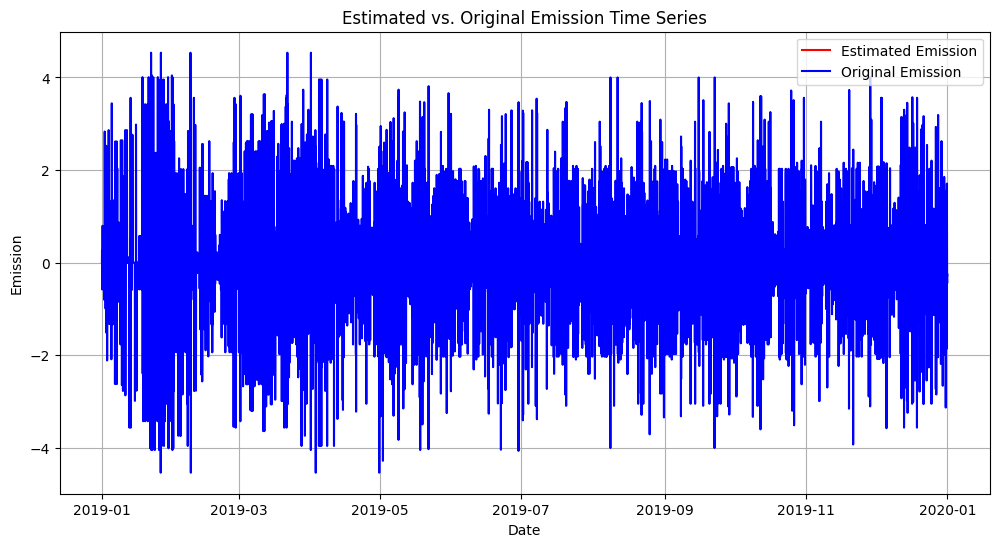

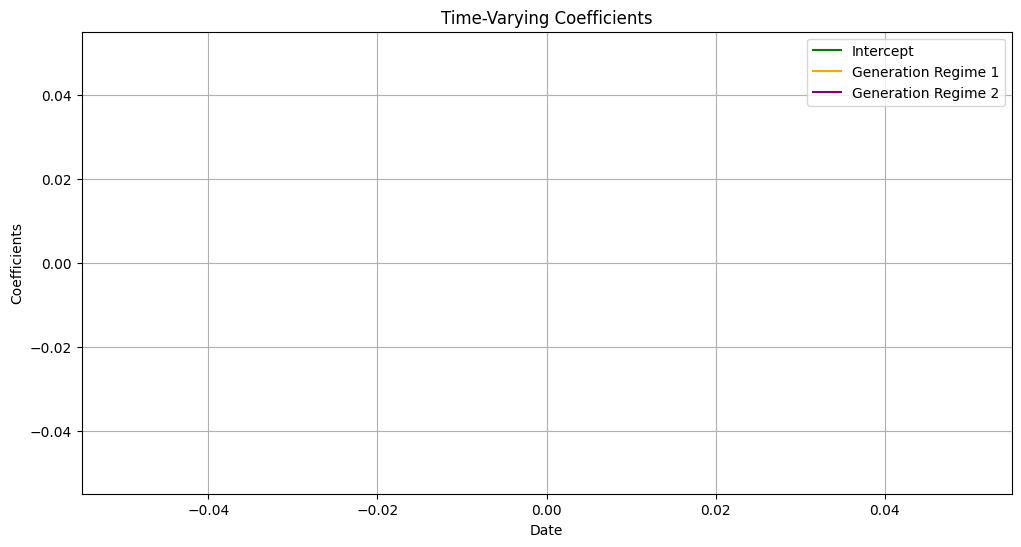

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Step 1: Read the data from the Excel file and preprocess it
# Replace 'your_file_path.xlsx' with the actual path to your Excel file
# ret = pd.read_excel('your_file_path.xlsx')
# ret.set_index('Date', inplace=True)  # Assuming you have a 'Date' column in your data

# Step 2: Implement the switching regime model with time-varying coefficients using training and testing samples
results = []  # To store the results for each testing sample

# Define the window size for rolling regression
window_size = 168

# Perform rolling regression
for i in range(window_size, len(ret)):
    sub_df = ret.iloc[i-window_size:i]

    train = sub_df.iloc[:-1]
    test = sub_df.iloc[-1:]

    X_train = train['Generation'].values.reshape(-1, 1)
    y_train = train['Emissions'].values
    X_test = test['Generation'].values.reshape(-1, 1)
    y_test = test['Emissions'].values

    try:
        # Fit the model with a maximum of 100 iterations
        msdr_model = sm.tsa.MarkovRegression(
            endog=y_train,
            k_regimes=2,
            trend='c',
            exog=X_train,
            switching_variance=True
        )
        msdr_results = msdr_model.fit(maxiter=100)

        # Forecast the emission time series using the model results
        forecast = msdr_results.predict(start=len(train), end=len(train))
        results.append((test.index[0], forecast[0]))
        print(f"Model estimated successfully for test sample ending on {test.index[0]}.")
    except Exception as e:
        print(f"Failed to estimate model for test sample ending on {test.index[0]} due to convergence issue: {e}")

# Step 3: Create a DataFrame to store the estimated emission time series
estimated_ret = pd.DataFrame(results, columns=['Date', 'Estimated_Emission'])
estimated_ret.set_index('Date', inplace=True)

# Save the estimated emission to an Excel file
estimated_ret.to_excel('estimated_emission.xlsx', index=True)

# Step 4: Save time-varying coefficients in Excel file
coefficients_ret = pd.DataFrame(columns=['Intercept', 'Generation_regime1', 'Generation_regime2'])
for i in range(len(results)):
    test_date, forecast = results[i]
    params = msdr_results.params  # Using the parameters from the last model fit
    coefficients_ret.loc[test_date] = [params[0], params[1], params[2]]

# Save the time-varying coefficients to an Excel file
coefficients_ret.to_excel('time_varying_coefficients.xlsx', index=True)

# Step 5: Plot the estimated emission time series and the time-varying coefficients

# Plot estimated emission time series
plt.figure(figsize=(12, 6))
plt.plot(estimated_ret.index, estimated_ret['Estimated_Emission'], label='Estimated Emission', color='red')
plt.plot(ret.index, ret['Emissions'], label='Original Emission', color='blue')
plt.xlabel('Date')
plt.ylabel('Emission')
plt.legend()
plt.title('Estimated vs. Original Emission Time Series')
plt.grid(True)
plt.savefig('emission_comparison.png')
plt.show()

# Plot time-varying coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_ret.index, coefficients_ret['Intercept'], label='Intercept', color='green')
plt.plot(coefficients_ret.index, coefficients_ret['Generation_regime1'], label='Generation Regime 1', color='orange')
plt.plot(coefficients_ret.index, coefficients_ret['Generation_regime2'], label='Generation Regime 2', color='purple')
plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Time-Varying Coefficients')
plt.grid(True)
plt.savefig('time_varying_coefficients.png')
plt.show()
